In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Dữ liệu Lịch sử HSG.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')

In [3]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)


In [4]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [5]:
df

,Date,Close,Open,High,Low,Volume,percent_change
1348,2017-12-01,13830.5,13772.9,13917.0,13657.6,4.41M,0.84%
1347,2017-12-04,14781.4,14061.0,14781.4,13830.5,13.71M,6.88%
1346,2017-12-05,14522.1,15040.7,15242.4,14522.1,12.28M,-1.75%
1345,2017-12-06,14896.6,14464.4,15069.5,14320.4,9.47M,2.58%
1344,2017-12-07,14666.1,15098.3,15184.8,14550.9,5.52M,-1.55%
...,...,...,...,...,...,...,...
4,2023-04-24,14600.0,14900.0,15050.0,14400.0,8.29M,-2.34%
3,2023-04-25,14950.0,14700.0,15200.0,14700.0,6.78M,2.40%
2,2023-04-26,15700.0,14950.0,15700.0,14800.0,13.61M,5.02%
1,2023-04-27,15300.0,15750.0,15800.0,15250.0,10.65M,-2.55%


In [6]:
tranformData(df)

In [7]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [8]:
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...
2023-04-24,14600.0,14900.0,15050.0,14400.0,8290000.0,-0.0234
2023-04-25,14950.0,14700.0,15200.0,14700.0,6780000.0,0.0240
2023-04-26,15700.0,14950.0,15700.0,14800.0,13610000.0,0.0502


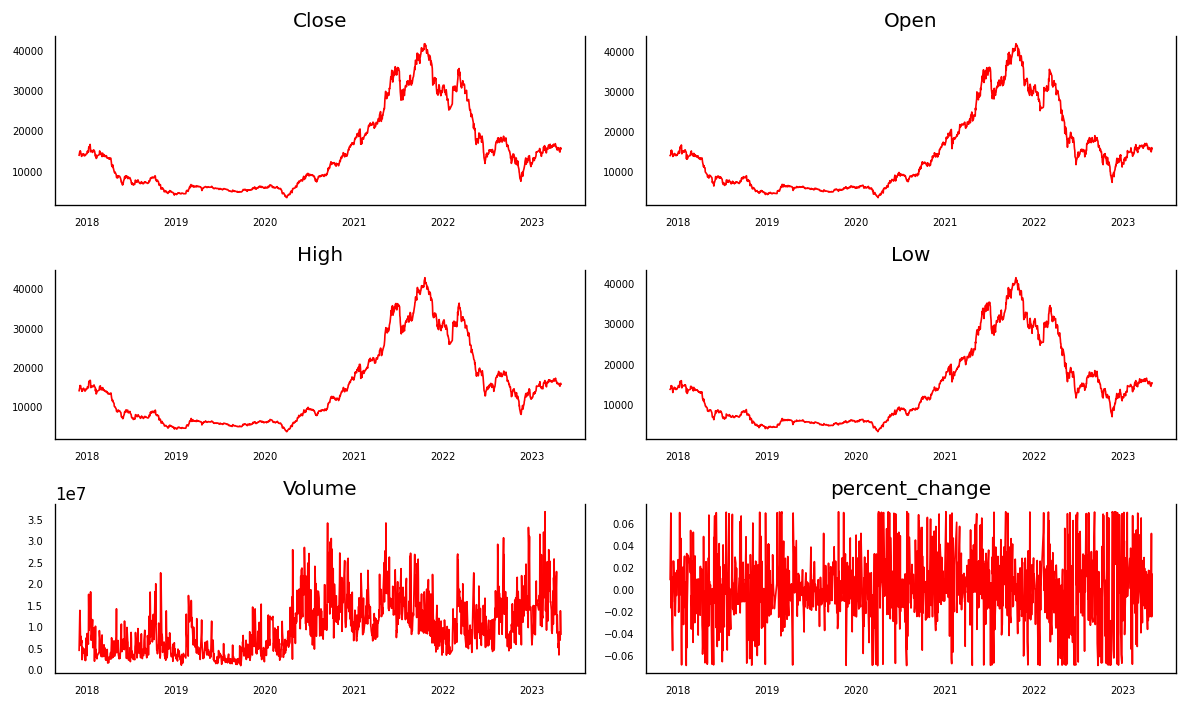

In [9]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [10]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Close_x,Open_x,High_x,Low_x,Volume_x,percent_change_x
Close_y,1.0000,0.0001,0.0006,0.0000,0.0001,0.0134
Open_y,0.0000,1.0000,0.0000,0.0000,0.0001,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0035,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Volume_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
percent_change_y,0.1443,0.3751,0.0354,0.3596,0.0065,1.0000


In [11]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  ::  685.68    > 83.9383   =>   True
Open   ::  455.78    > 60.0627   =>   True
High   ::  251.5     > 40.1749   =>   True
Low    ::  98.84     > 24.2761   =>   True
Volume ::  28.74     > 12.3212   =>   True
percent_change ::  0.46      > 4.1296    =>   False


In [12]:
nobs=int(0.2*len(df))
n_train = int(0.7 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(944, 6)
(269, 6)
(136, 6)


In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [14]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.0912
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.9988. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.7054
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.9981. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [15]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [16]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1961
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.894
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [17]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [18]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.1393
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.7686
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [19]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  69.818076834276
BIC :  70.03441223476759
FPE :  2.0970376187950228e+30
HQIC:  69.90054165131836 

Lag Order = 2
AIC :  68.1353095081745
BIC :  68.53741443399429
FPE :  3.897566535254052e+29
HQIC:  68.28859560492663 

Lag Order = 3
AIC :  67.20132671299662
BIC :  67.78951517373116
FPE :  1.5317213404825198e+29
HQIC:  67.42556107115396 

Lag Order = 4
AIC :  66.59124458808277
BIC :  67.36583146692173
FPE :  8.322292411927808e+28
HQIC:  66.88655455169652 

Lag Order = 5
AIC :  66.05379298530607
BIC :  67.0150940423993
FPE :  4.862512741397426e+28
HQIC:  66.42030626219506 

Lag Order = 6
AIC :  65.72149936589256
BIC :  66.86983124172377
FPE :  3.4881240631806025e+28
HQIC:  66.15934402906218 

Lag Order = 7
AIC :  65.42379676060125
BIC :  66.75947697937823
FPE :  2.5903777739493586e+28
HQIC:  65.93310124966948 

Lag Order = 8
AIC :  65.2218117016922
BIC :  66.74515867475353
FPE :  2.1170161640817204e+28
HQIC:  65.80270482432249 

Lag Order = 9
AIC :  65.01108239341785
B

In [212]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,73.81,73.85,1.140e+32,73.83
1,69.88,70.10,2.233e+30,69.96
2,68.19,68.60,4.135e+29,68.35
3,67.26,67.85,1.619e+29,67.48
4,66.64,67.43,8.747e+28,66.94
5,66.11,67.08,5.142e+28,66.48
6,65.77,66.93,3.660e+28,66.21
7,65.47,66.82,2.719e+28,65.99
8,65.26,66.80,2.209e+28,65.85
9,65.06,66.78*,1.793e+28,65.71


In [233]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Jun, 2023
Time:                     23:30:39
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    66.7452
Nobs:                     934.000    HQIC:                   65.8027
Log likelihood:          -38116.3    FPE:                2.11702e+28
AIC:                      65.2218    Det(Omega_mle):     1.55770e+28
--------------------------------------------------------------------
Results for equation Close
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     3.858476        13.508567            0.286           0.775
L1.Close                 -0.777136         0.087334           -8.898           0.000
L1.Open                  -0.121913         0

In [234]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

8


array([[ 2.2083e+03,  2.0833e+03,  2.1249e+03,  1.0416e+03,  1.4820e+07,
         6.7300e-02],
       [-2.9583e+03,  1.3750e+03, -1.3332e+03,  2.9170e+02, -2.0320e+07,
        -1.5350e-01],
       [ 1.7500e+03, -3.6667e+03, -6.2510e+02, -1.6666e+03,  6.9600e+06,
         1.3700e-01],
       [ 8.3400e+01,  2.6667e+03,  1.1250e+03,  1.7916e+03, -4.4000e+05,
        -4.8300e-02],
       [-1.2084e+03, -5.8330e+02, -1.0416e+03, -9.5840e+02, -7.7200e+06,
        -3.4700e-02],
       [-9.1670e+02, -9.1670e+02, -3.7500e+02, -9.9990e+02,  9.1300e+06,
         8.9000e-03],
       [ 8.7500e+02, -1.1250e+03, -4.1670e+02,  4.5830e+02, -6.2400e+06,
         4.7900e-02],
       [ 2.5417e+03,  1.0833e+03,  2.5833e+03, -2.5000e+02,  1.6940e+07,
         4.6300e-02]])

In [235]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2021-09-16,-2359.023536,2970.402082,-889.975117,2635.922808,-1.646666e+07,-1.496966e-01
2021-09-17,580.729176,-3457.838196,-1053.917769,-2412.628521,4.358968e+06,1.261582e-01
2021-09-20,-450.059850,1536.213378,880.932333,719.711508,1.463775e+06,-7.016516e-02
2021-09-21,237.383641,-896.406609,-797.226742,-469.791640,-7.738924e+06,1.758757e-02
2021-09-22,-50.457864,475.883385,669.198942,209.588111,8.858469e+06,1.785811e-02
...,...,...,...,...,...,...
2022-10-06,0.680736,0.648619,0.753979,0.611160,1.431578e+03,-3.736109e-07
2022-10-07,0.680735,0.648619,0.753979,0.611160,1.431578e+03,-3.736109e-07
2022-10-10,0.680735,0.648619,0.753979,0.611160,1.431578e+03,-3.736109e-07


In [236]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Close_2d,Open_2d,High_2d,Low_2d,Volume_2d,percent_change_2d
Date,,,,,,
2022-10-13,-2359.023536,2970.402082,-889.975117,2635.922808,-1.646666e+07,-1.496966e-01
2022-10-14,580.729176,-3457.838196,-1053.917769,-2412.628521,4.358968e+06,1.261582e-01
2022-10-17,-450.059850,1536.213378,880.932333,719.711508,1.463775e+06,-7.016516e-02
2022-10-18,237.383641,-896.406609,-797.226742,-469.791640,-7.738924e+06,1.758757e-02
2022-10-19,-50.457864,475.883385,669.198942,209.588111,8.858469e+06,1.785811e-02
...,...,...,...,...,...,...
2023-04-24,0.681275,0.648716,0.754252,0.611280,1.433512e+03,-3.790659e-07
2023-04-25,0.680799,0.649280,0.754204,0.611981,1.430828e+03,-3.649103e-07
2023-04-26,0.680820,0.648749,0.753836,0.611157,1.430604e+03,-3.597694e-07


In [237]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [238]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [239]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2022-10-13,39099.276464,39262.002082,40068.324883,38510.922808,2.064334e+07,-0.011397
2022-10-14,39820.982104,38732.865968,40082.731996,38484.217096,2.106565e+07,0.034765
2022-10-17,40092.627893,39739.943232,40978.071442,39177.222892,2.295174e+07,0.010761
2022-10-18,40601.657324,39850.613887,41076.184146,39400.437047,1.709890e+07,0.004345
2022-10-19,41060.228891,40437.167927,41843.495793,39833.239314,2.010453e+07,0.015787
...,...,...,...,...,...,...
2023-04-24,114346.622292,107216.326754,118367.785987,105518.829975,7.475186e+07,-0.079466
2023-04-25,114966.967790,107784.701515,119019.023372,106075.445212,7.526598e+07,-0.080200
2023-04-26,115587.994108,108353.725024,119671.014593,106632.671606,7.578152e+07,-0.080934


In [240]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Volume_forecast', 'percent_change_forecast']]

,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
Date,,,,,,
2021-09-16,39099.276464,39262.002082,40068.324883,38510.922808,2.064334e+07,-0.011397
2021-09-17,39820.982104,38732.865968,40082.731996,38484.217096,2.106565e+07,0.034765
2021-09-20,40092.627893,39739.943232,40978.071442,39177.222892,2.295174e+07,0.010761
2021-09-21,40601.657324,39850.613887,41076.184146,39400.437047,1.709890e+07,0.004345
2021-09-22,41060.228891,40437.167927,41843.495793,39833.239314,2.010453e+07,0.015787
...,...,...,...,...,...,...
2022-10-06,202828.034000,188503.723826,211600.751786,184913.363647,1.556950e+08,-0.180364
2022-10-07,203538.917048,189158.364718,212352.268132,185551.262718,1.563995e+08,-0.181148
2022-10-10,204250.480833,189813.654228,213104.538457,186189.772948,1.571054e+08,-0.181932


In [241]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Close_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast', 'Volume_forecast', 'percent_change_forecast']]


,Close_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast,percent_change_forecast
0,39099.276464,39262.002082,40068.324883,38510.922808,2.064334e+07,-0.011397
1,39820.982104,38732.865968,40082.731996,38484.217096,2.106565e+07,0.034765
2,40092.627893,39739.943232,40978.071442,39177.222892,2.295174e+07,0.010761
3,40601.657324,39850.613887,41076.184146,39400.437047,1.709890e+07,0.004345
4,41060.228891,40437.167927,41843.495793,39833.239314,2.010453e+07,0.015787
...,...,...,...,...,...,...
264,202828.034000,188503.723826,211600.751786,184913.363647,1.556950e+08,-0.180364
265,203538.917048,189158.364718,212352.268132,185551.262718,1.563995e+08,-0.181148
266,204250.480833,189813.654228,213104.538457,186189.772948,1.571054e+08,-0.181932
267,204962.725352,190469.592357,213857.562761,186828.894339,1.578128e+08,-0.182716


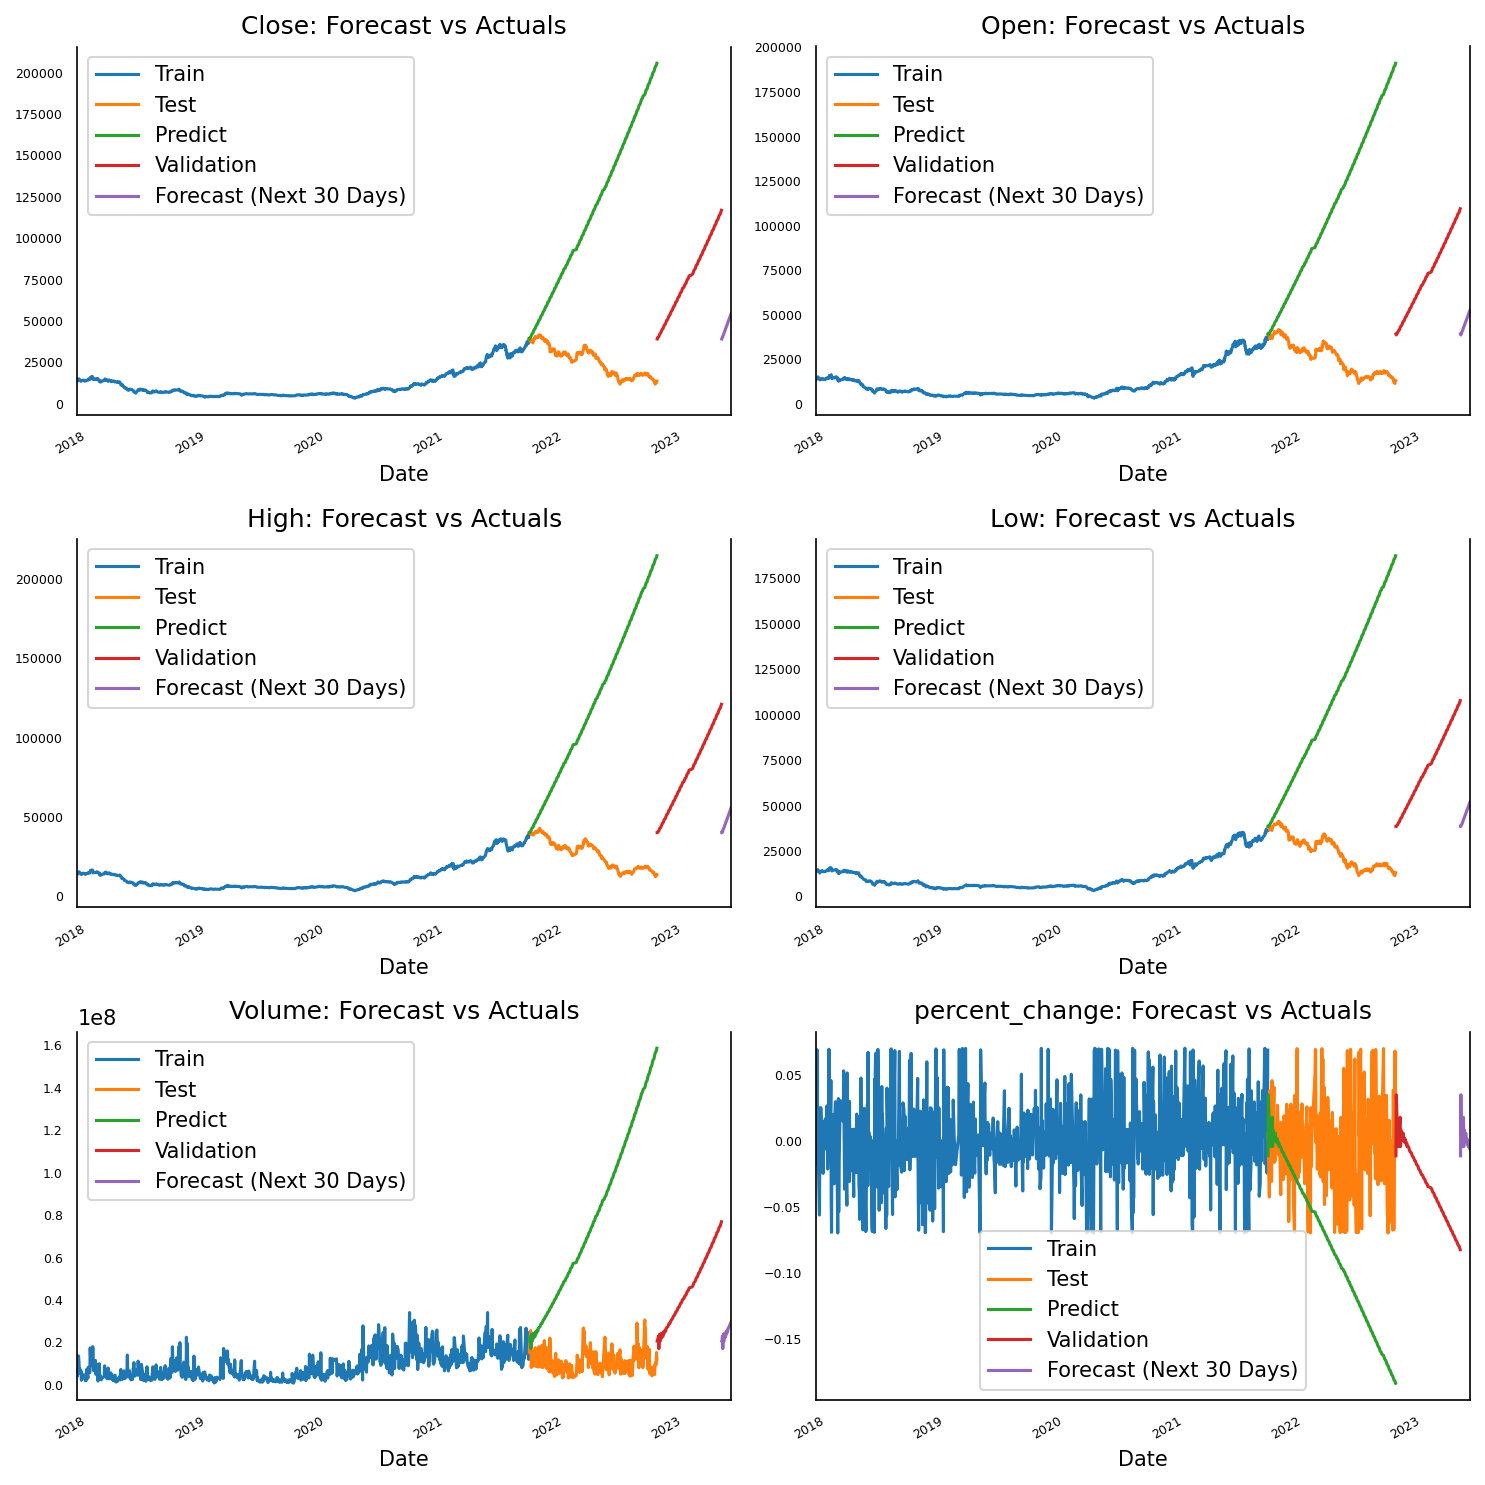

In [242]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    df_train[col].plot(legend=True, ax=ax, label='Train')
    df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')
    df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)
    df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)
    df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()
